In [121]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb 

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.data_fetching as data_fetching
import Components.feature_extraction as feature_extraction
import Components.Classifying_Transformer as clt
import Components.Smoothing_Classifier as smcl

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(data_fetching)
importlib.reload(feature_extraction)
importlib.reload(clt)
importlib.reload(smcl)

<module 'Components.Smoothing_Classifier' from '../Components/Smoothing_Classifier.py'>

# Data Fetching

In [2]:
_, y = data_fetching.get_train_data()
y = np.ravel(y)

In [94]:
X = feature_extraction.get_features(None, precomputed='train')
X_test = feature_extraction.get_features(None, precomputed='test')

# Cross-validation

In [109]:
tr = clt.Classifying_Transformer(lgb.LGBMClassifier(class_weight = 'balanced'))
output = tr.fit_transform(X,y)
output

array([[3],
       [3],
       [2],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
output.

In [103]:
pd.DataFrame(output)

,0
0,3
1,3
2,2
3,3
4,3
...,...
64795,1
64796,1
64797,1
64798,1


In [133]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('individual_classification', clt.Classifying_Transformer(lgb.LGBMClassifier(class_weight = 'balanced'))),
                 ('smoothing', smcl.Smoothing_Classifier(lgb.LGBMClassifier(class_weight = 'balanced'), lag= 200, border_vote = 5))])

In [123]:
pipe.fit(X,y)
pipe.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [135]:
# 10-fold cross validation
cv_score = cross_val_score(pipe, X, y, cv=10, scoring='balanced_accuracy', n_jobs=16)
print(cv_score)
print(np.mean(cv_score))

# Results
# Univariate:
# [0.89757557 0.92140442 0.93921128 0.93053365 0.92786127 0.94813602
#  0.94736384 0.93639493 0.92317302 0.90670064]
# 0.9278354652022862

# Univariate + Bivariate:
#[0.90347486 0.92410507 0.94056357 0.93016137 0.92783613 0.94582218
# 0.95304799 0.93762358 0.92989084 0.89881094]
#0.9291336524084614

#LGB balanced all MNE features
#[0.91248291 0.93757551 0.93776122 0.94559858 0.94700759 0.95800639
 #0.96195897 0.96088698 0.95638669 0.93146697]
#0.9449131810551336

# both steps LGB, lag 5, border-vote 5
#[0.91492283 0.929152   0.95049465 0.92541262 0.95753246 0.9655349
# 0.95613847 0.89900996 0.94648237 0.92929171]
#0.9373971958502845

# both steps LGB, lag 10, border-vote 5
#[0.91446038 0.93173807 0.95028022 0.92681036 0.96407263 0.96591643
# 0.95648627 0.92441876 0.94677756 0.93393272]
#0.9414893410715848

# both steps LGB, lag 100, border-vote 5
#[0.91397036 0.9346743  0.95067074 0.9264629  0.96606772 0.9643442
# 0.95588623 0.93290301 0.94710545 0.93966206]
# 0.9431746972865408

# both steps LGB, lag 200, border-vote 5
#[0.9153276  0.93434409 0.95115538 0.92700013 0.96559198 0.96464306
# 0.95661966 0.92412377 0.94592372 0.94286516]
# 0.9427594548092839


[0.9153276  0.93434409 0.95115538 0.92700013 0.96559198 0.96464306
 0.95661966 0.92412377 0.94592372 0.94286516]
0.9427594548092839


In [134]:
# Train on 2 subjects, test on the other
n_epochs = 21600
splits = [(np.r_[0:2*n_epochs], np.r_[2*n_epochs:3*n_epochs]),
 (np.r_[0:n_epochs, 2*n_epochs:3*n_epochs], np.r_[n_epochs:2*n_epochs]),
 (np.r_[n_epochs:3*n_epochs], np.r_[0:n_epochs])]

# format: 
# [(train_indices, test_indices),
#    (train_indices, test_indices),....]

cv_score = cross_val_score(pipe, X, y, cv=splits, scoring='balanced_accuracy',n_jobs=16)
print(cv_score)
print(np.mean(cv_score))

#LGB all MNE features
#[0.70943547 0.95720017 0.88320811]
#0.8499479178461647

# both steps LGB, lag 5, border-vote 5
#[0.5997921  0.95668261 0.8793381 ]
#0.8119376038984457

# both steps LGB, lag 10, border-vote 5
#[0.60192032 0.95705123 0.87927879]
#0.8127501105221282

# both steps LGB, lag 100, border-vote 5
#[0.60703004 0.95650736 0.8793381 ]
#0.814291835327246

# both steps LGB, lag 200, border-vote 5
#[0.5985031  0.95719145 0.87924913]
#0.8116478914896422

[0.5985031  0.95719145 0.87924913]
0.8116478914896422


# Prediction

In [27]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('classification', lgb.LGBMClassifier(class_weight = 'balanced'))])

(array([19575.,     0.,     0.,     0.,     0., 21814.,     0.,     0.,
            0.,  1811.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

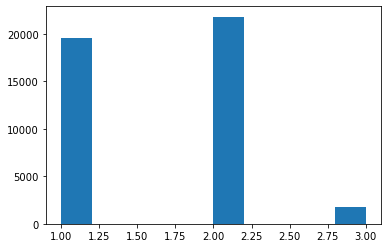

In [4]:
pipe.fit(X,y)
y_pred = pipe.predict(X_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/LGB_Standard_MNE_Features_All.csv', index_label='Id')

# Plots

**sleep stages of first subject**

In [29]:
n_epochs = 21600
X_train_split = X[:2*n_epochs]
y_train_split = y[:2*n_epochs]
pipe.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classification', LGBMClassifier(class_weight='balanced'))])

In [30]:
y_train_pred = pipe.predict(X[2*n_epochs:])

In [66]:
y_ind_pred =y_train_pred
border_vote = 5
lag = 3

In [79]:
X = pd.DataFrame(y_ind_pred)
# earlier values
start_border = np.bincount(y_ind_pred[:border_vote-1]).argmax()
for f in range(-1* lag, 0):
    X[f] = X[0].shift(periods=-f, fill_value = start_border)
end_border = np.bincount(y_ind_pred[-1*border_vote:]).argmax()
# later values
for f in range(1,lag + 1):
    X[f] = X[0].shift(periods=-f, fill_value = end_border)

In [81]:
X.iloc[:10]

,0,-3,-2,-1,1,2,3
0,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2
2,2,2,2,2,2,2,1
3,2,2,2,2,2,1,1
4,2,2,2,2,1,1,1
5,1,2,2,2,1,1,1
6,1,2,2,1,1,1,1
7,1,2,1,1,1,1,1
8,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1


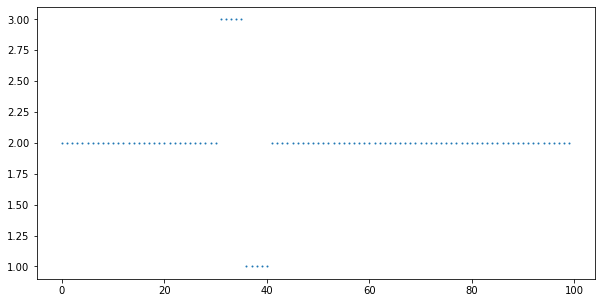

In [83]:
stages=y[2*n_epochs+9000:2*n_epochs+9100]
time = range(len(stages))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages, s=1)

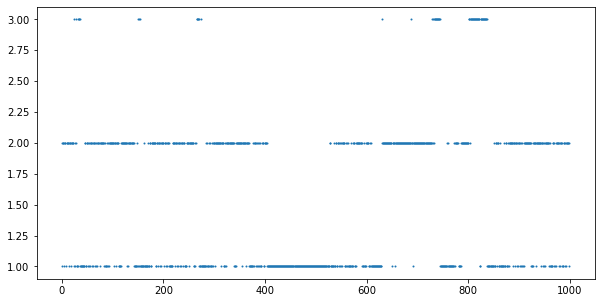

In [61]:
stages_pred = y_train_pred[9000:10000]
time = range(len(stages_pred))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages_pred, s=1)